Minimum steps required: 11


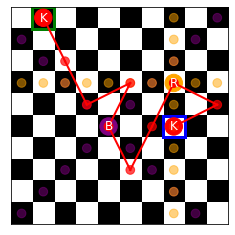

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
import math

class Cell:
    def __init__(self, x=0, y=0, dist=0, parent=None):
        self.x = x
        self.y = y
        self.dist = dist
        self.parent = parent

def create_chessboard(N):
    base_row = np.tile([1, 0], (N + 1) // 2)[:N]
    board = np.tile(base_row, (N, 1))
    for i in range(N):
        if i % 2 != 0:
            board[i] = np.roll(board[i], 1)
    return board

def plot_chessboard(ax, board):
    ax.imshow(board, cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

def plot_piece(ax, position, color, label):
    ax.add_patch(patches.Circle((position[1], position[0]), 0.4, color=color, fill=True))
    ax.text(position[1], position[0], label, color='white', fontsize=12, ha='center', va='center')

def plot_square(ax, position, color, linewidth):
    ax.add_patch(patches.Rectangle((position[1] - 0.5, position[0] - 0.5), 1, 1, edgecolor=color, facecolor='none', lw=linewidth))

def is_inside(x, y, N):
    return 0 <= x < N and 0 <= y < N

def is_threatened_by_bishop(x, y, bishopRow, bishopCol):
    return abs(x - bishopRow) == abs(y - bishopCol)

def is_threatened_by_rook(x, y, rookRow, rookCol):
    return x == rookRow or y == rookCol

def is_target_blocked(endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
    return is_threatened_by_bishop(endRow, endCol, bishopRow, bishopCol) or is_threatened_by_rook(endRow, endCol, rookRow, rookCol)

def find_path(n, startRow, startCol, targetRow, targetCol, bishopRow, bishopCol, rookRow, rookCol, avoid_threats=True):
    moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    visited = set()
    queue = deque([Cell(startRow, startCol, 0)])
    visited.add((startRow, startCol))

    while queue:
        t = queue.popleft()
        tx, ty = t.x, t.y

        if tx == targetRow and ty == targetCol:
            path = []
            while t:
                path.append((t.x, t.y))
                t = t.parent
            return path[::-1]

        for di, dj in moves:
            cr, cc = tx + di, ty + dj
            if not is_inside(cr, cc, n) or (cr, cc) in visited:
                continue

            if avoid_threats and (is_threatened_by_bishop(cr, cc, bishopRow, bishopCol) or is_threatened_by_rook(cr, cc, rookRow, rookCol)):
                continue

            visited.add((cr, cc))
            queue.append(Cell(cr, cc, t.dist + 1, t))

    return None

def capture_obstacle(n, startRow, startCol, bishopRow, bishopCol, rookRow, rookCol):
    if is_inside(bishopRow, bishopCol, n):
        path_to_bishop = find_path(n, startRow, startCol, bishopRow, bishopCol, bishopRow, bishopCol, rookRow, rookCol, avoid_threats=False)
        if path_to_bishop:
            return path_to_bishop, 'bishop'
    if is_inside(rookRow, rookCol, n):
        path_to_rook = find_path(n, startRow, startCol, rookRow, rookCol, bishopRow, bishopCol, rookRow, rookCol, avoid_threats=False)
        if path_to_rook:
            return path_to_rook, 'rook'
    return None, None

def moves(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
    full_path = []

    while is_target_blocked(endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
        path_to_obstacle, obstacle_type = capture_obstacle(n, startRow, startCol, bishopRow, bishopCol, rookRow, rookCol)
        if not path_to_obstacle:
            return -1, None
        full_path.extend(path_to_obstacle)
        if obstacle_type == 'bishop':
            bishopRow, bishopCol = -1, -1  # Mark bishop as captured
        elif obstacle_type == 'rook':
            rookRow, rookCol = -1, -1  # Mark rook as captured
        startRow, startCol = full_path[-1]

    path_to_target = find_path(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol)
    if path_to_target:
        full_path.extend(path_to_target)
        return len(full_path) - 1, full_path
    else:
        return -1, None

def plot_threatened_squares(ax, n, bishopRow, bishopCol, rookRow, rookCol):
    if bishopRow < n and bishopCol < n:
        for i in range(n):
            for j in range(n):
                if abs(bishopRow - i) == abs(bishopCol - j) and (i != bishopRow or j != bishopCol):
                    ax.add_patch(patches.Circle((j, i), 0.2, color='purple', fill=True, alpha=0.5))

    if rookRow < n and rookCol < n:
        for i in range(n):
            if i != rookRow:
                ax.add_patch(patches.Circle((rookCol, i), 0.2, color='orange', fill=True, alpha=0.5))
            if i != rookCol:
                ax.add_patch(patches.Circle((i, rookRow), 0.2, color='orange', fill=True, alpha=0.5))

def draw_path(ax, path):
    for (i, j) in path:
        ax.add_patch(patches.Circle((j, i), 0.2, color='red', fill=True, alpha=0.7))
    for k in range(len(path) - 1):
        (i1, j1), (i2, j2) = path[k], path[k + 1]
        ax.plot([j1, j2], [i1, i2], color='red', linewidth=2)

# Configurazione e visualizzazione della scacchiera e dei pezzi
N = 10
startRow, startCol = 0, 1
endRow, endCol = 5, 7
bishopRow, bishopCol = 5, 4
rookRow, rookCol = 3, 7

board = create_chessboard(N)
fig, ax = plt.subplots()
plot_chessboard(ax, board)
plot_square(ax, (startRow, startCol), 'green', 3)
plot_square(ax, (endRow, endCol), 'blue', 3)
plot_piece(ax, (startRow, startCol), 'red', 'K')
plot_piece(ax, (bishopRow, bishopCol), 'purple', 'B')
plot_piece(ax, (rookRow, rookCol), 'orange', 'R')
plot_piece(ax, (endRow, endCol), 'red', 'K')
plot_threatened_squares(ax, N, bishopRow, bishopCol, rookRow, rookCol)

result = moves(N, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol)
if result != -1:
    steps, path = result
    draw_path(ax, path)
    print(f"Minimum steps required: {steps}")
else:
    print("No path found to reach the target.")

plt.show()


No path found to reach the target.


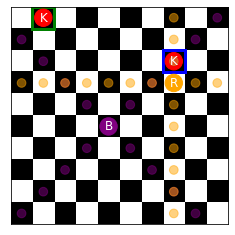

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque

class Cell:
    def __init__(self, x=0, y=0, dist=0, parent=None):
        self.x = x
        self.y = y
        self.dist = dist
        self.parent = parent

def create_chessboard(N):
    base_row = np.tile([1, 0], (N + 1) // 2)[:N]
    board = np.tile(base_row, (N, 1))
    for i in range(N):
        if i % 2 != 0:
            board[i] = np.roll(board[i], 1)
    return board

def plot_chessboard(ax, board):
    ax.imshow(board, cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

def plot_piece(ax, position, color, label):
    ax.add_patch(patches.Circle((position[1], position[0]), 0.4, color=color, fill=True))
    ax.text(position[1], position[0], label, color='white', fontsize=12, ha='center', va='center')

def plot_square(ax, position, color, linewidth):
    ax.add_patch(patches.Rectangle((position[1] - 0.5, position[0] - 0.5), 1, 1, edgecolor=color, facecolor='none', lw=linewidth))

def is_inside(x, y, N):
    return 0 <= x < N and 0 <= y < N

def is_threatened_by_bishop(x, y, bishopRow, bishopCol):
    return abs(x - bishopRow) == abs(y - bishopCol)

def is_threatened_by_rook(x, y, rookRow, rookCol):
    return x == rookRow or y == rookCol

def is_threatened(x, y, bishopRow, bishopCol, rookRow, rookCol):
    return is_threatened_by_bishop(x, y, bishopRow, bishopCol) or is_threatened_by_rook(x, y, rookRow, rookCol)

def find_path(n, startRow, startCol, targetRow, targetCol, bishopRow, bishopCol, rookRow, rookCol):
    moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    visited = set()
    queue = deque([Cell(startRow, startCol, 0)])
    visited.add((startRow, startCol))

    while queue:
        t = queue.popleft()
        tx, ty = t.x, t.y

        if tx == targetRow and ty == targetCol:
            path = []
            while t:
                path.append((t.x, t.y))
                t = t.parent
            return path[::-1]

        for di, dj in moves:
            cr, cc = tx + di, ty + dj
            if not is_inside(cr, cc, n) or (cr, cc) in visited:
                continue

            if is_threatened(cr, cc, bishopRow, bishopCol, rookRow, rookCol):
                continue

            visited.add((cr, cc))
            queue.append(Cell(cr, cc, t.dist + 1, t))

    return None

def capture_obstacle(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
    path_to_bishop, path_to_rook = None, None
    if is_threatened_by_bishop(endRow, endCol, bishopRow, bishopCol):
        path_to_bishop = find_path(n, startRow, startCol, bishopRow, bishopCol, bishopRow, bishopCol, rookRow, rookCol)
    if is_threatened_by_rook(endRow, endCol, rookRow, rookCol):
        path_to_rook = find_path(n, startRow, startCol, rookRow, rookCol, bishopRow, bishopCol, rookRow, rookCol)
    
    if path_to_bishop and (not path_to_rook or len(path_to_bishop) <= len(path_to_rook)):
        return path_to_bishop, 'bishop'
    if path_to_rook:
        return path_to_rook, 'rook'
    
    return None, None

def moves(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
    full_path = []

    while is_target_blocked(endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
        path_to_obstacle, obstacle_type = capture_obstacle(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol)
        if path_to_obstacle is None:
            return -1, None
        full_path.extend(path_to_obstacle)
        if obstacle_type == 'bishop':
            bishopRow, bishopCol = -1, -1  # Mark bishop as captured
        elif obstacle_type == 'rook':
            rookRow, rookCol = -1, -1  # Mark rook as captured
        startRow, startCol = full_path[-1]

    path_to_target = find_path(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol)
    if path_to_target is not None:
        full_path.extend(path_to_target)
        return len(full_path) - 1, full_path
    else:
        return -1, None

def plot_threatened_squares(ax, n, bishopRow, bishopCol, rookRow, rookCol):
    if bishopRow < n and bishopCol < n:
        for i in range(n):
            for j in range(n):
                if abs(bishopRow - i) == abs(bishopCol - j) and (i != bishopRow or j != bishopCol):
                    ax.add_patch(patches.Circle((j, i), 0.2, color='purple', fill=True, alpha=0.5))

    if rookRow < n and rookCol < n:
        for i in range(n):
            if i != rookRow:
                ax.add_patch(patches.Circle((rookCol, i), 0.2, color='orange', fill=True, alpha=0.5))
            if i != rookCol:
                ax.add_patch(patches.Circle((i, rookRow), 0.2, color='orange', fill=True, alpha=0.5))

def draw_path(ax, path):
    for (i, j) in path:
        ax.add_patch(patches.Circle((j, i), 0.3, color='red', fill=True, alpha=0.7))
    for k in range(len(path) - 1):
        (i1, j1), (i2, j2) = path[k], path[k + 1]
        ax.plot([j1, j2], [i1, i2], color='red', linewidth=2)

# Configurazione e visualizzazione della scacchiera e dei pezzi
N = 10
startRow, startCol = 0, 1
endRow, endCol = 2, 7
bishopRow, bishopCol = 5, 4
rookRow, rookCol = 3, 7

board = create_chessboard(N)
fig, ax = plt.subplots()
plot_chessboard(ax, board)
plot_square(ax, (startRow, startCol), 'green', 3)
plot_square(ax, (endRow, endCol), 'blue', 3)
plot_piece(ax, (startRow, startCol), 'red', 'K')
plot_piece(ax, (bishopRow, bishopCol), 'purple', 'B')
plot_piece(ax, (rookRow, rookCol), 'orange', 'R')
plot_piece(ax, (endRow, endCol), 'red', 'K')
plot_threatened_squares(ax, N, bishopRow, bishopCol, rookRow, rookCol)

result = moves(N, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol)
if result != -1:
    steps, path = result
    if path is not None:
        draw_path(ax, path)
        print(f"Minimum steps required: {steps}")
    else:
        print("No path found to reach the target.")
else:
    print("No path found to reach the target.")

plt.show()


In [3]:
# Funziona per la torre
def is_threatened_by_bishop(x, y, bishopRow, bishopCol):
    return abs(x - bishopRow) == abs(y - bishopCol)

def is_threatened_by_rook(x, y, rookRow, rookCol):
    return x == rookRow or y == rookCol

def is_target_blocked(endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
    return (is_threatened_by_bishop(endRow, endCol, bishopRow, bishopCol) or
            is_threatened_by_rook(endRow, endCol, rookRow, rookCol))

def find_path(n, startRow, startCol, targetRow, targetCol, bishopRow, bishopCol, rookRow, rookCol, avoid_threats=True):
    moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    visited = set()
    queue = deque([cell(startRow, startCol, 0)])
    visited.add((startRow, startCol))

    while queue:
        t = queue.popleft()
        tx, ty = t.x, t.y

        if tx == targetRow and ty == targetCol:
            path = []
            while t:
                path.append((t.x, t.y))
                t = t.parent
            return path[::-1]

        for di, dj in moves:
            cr, cc = tx + di, ty + dj
            if cr < 0 or cr >= n or cc < 0 or cc >= n:
                continue
            if (cr, cc) in visited:
                continue

            if avoid_threats:
                if is_threatened_by_bishop(cr, cc, bishopRow, bishopCol) or is_threatened_by_rook(cr, cc, rookRow, rookCol):
                    continue

            visited.add((cr, cc))
            queue.append(cell(cr, cc, t.dist + 1, t))

    return None

def moves(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
    full_path = []

    # Verifica se il target è bloccato da un ostacolo
    if is_target_blocked(endRow, endCol, bishopRow, bishopCol, rookRow, rookCol):
        # Se il target è bloccato dall'alfiere, trova il percorso per catturare l'alfiere
        if is_threatened_by_bishop(endRow, endCol, bishopRow, bishopCol):
            path_to_bishop = find_path(n, startRow, startCol, bishopRow, bishopCol, bishopRow, bishopCol, rookRow, rookCol, avoid_threats=False)
            if path_to_bishop:
                full_path.extend(path_to_bishop)
                for (cr, cc) in path_to_bishop:
                    if cr == bishopRow and cc == bishopCol:
                        bishopRow, bishopCol = math.inf, math.inf
                        startRow, startCol = cr, cc
                        break
            else:
                return -1
        
        # Se il target è bloccato dalla torre, trova il percorso per catturare la torre
        if is_threatened_by_rook(endRow, endCol, rookRow, rookCol):
            path_to_rook = find_path(n, startRow, startCol, rookRow, rookCol, bishopRow, bishopCol, rookRow, rookCol, avoid_threats=False)
            if path_to_rook:
                full_path.extend(path_to_rook)
                for (cr, cc) in path_to_rook:
                    if cr == rookRow and cc == rookCol:
                        rookRow, rookCol = math.inf, math.inf
                        startRow, startCol = cr, cc
                        break
            else:
                return -1

    # Trova il percorso finale verso il target
    path_to_target = find_path(n, startRow, startCol, endRow, endCol, bishopRow, bishopCol, rookRow, rookCol)
    if path_to_target:
        full_path.extend(path_to_target)
        return len(full_path) - 1, full_path
    else:
        return -1
